In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = pd.read_csv("./Accuracy Revised.csv")

In [3]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


# EDA

In [4]:
accuracy.head()

,Date,QBO,QBSE,Mint
0,1-Jan-18,0.541773,0.562901,NaN
1,2-Jan-18,0.555210,0.615290,NaN
2,3-Jan-18,0.559857,0.646905,NaN
3,4-Jan-18,0.545718,0.557536,NaN
4,5-Jan-18,0.539705,0.568850,NaN


In [5]:
accuracy.describe()

,QBO,QBSE,Mint
count,479.000000,476.000000,306.000000
mean,0.634646,0.630418,0.971331
std,0.085989,0.099211,0.008695
min,0.363974,0.318323,0.954104
25%,0.564578,0.615173,0.964081
50%,0.644814,0.669324,0.968719
75%,0.709895,0.682226,0.979515
max,0.776034,0.772107,0.993386


In [6]:
accuracy.dtypes

Date     object
QBO     float64
QBSE    float64
Mint    float64
dtype: object

In [7]:
accuracy.shape

(479, 4)

In [8]:
accuracy['Date'] = pd.to_datetime(accuracy.Date)

In [9]:
accuracy = accuracy.set_index('Date')

In [10]:
accuracy.head()

,QBO,QBSE,Mint
Date,,,
2018-01-01,0.541773,0.562901,NaN
2018-01-02,0.555210,0.615290,NaN
2018-01-03,0.559857,0.646905,NaN
2018-01-04,0.545718,0.557536,NaN
2018-01-05,0.539705,0.568850,NaN


In [11]:
#check null values by time series
accuracy.isna().sum()

QBO       0
QBSE      3
Mint    173
dtype: int64

# Plot the model performance metrics

Text(0, 0.5, 'Model Accuracy')

<Figure size 720x432 with 0 Axes>

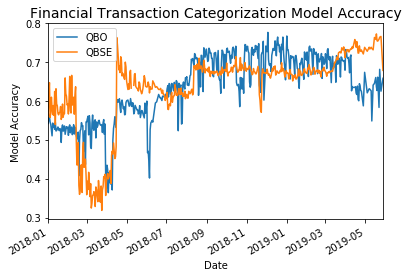

In [12]:
plt.figure(figsize=(10,6))
accuracy[['QBO', 'QBSE']].plot()
plt.title("Financial Transaction Categorization Model Accuracy", fontsize = 14)
plt.ylabel("Model Accuracy")

# Detect Anomalies with ARIMA Model

### Step 1: Check Stationarity

In [13]:
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot

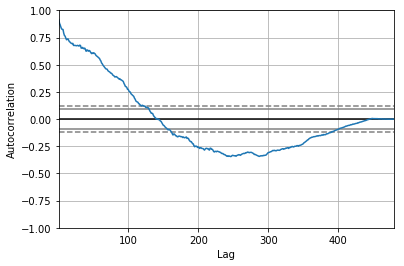

In [14]:
autocorrelation_plot(accuracy.QBO)
plt.show()

#plot the ACF of the original QBO time series

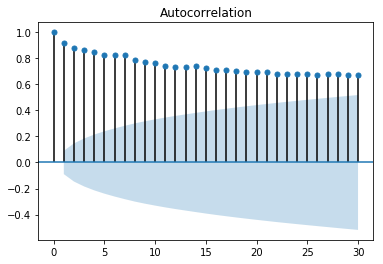

In [15]:
plot_acf(accuracy.QBO.values, lags=30)
plt.show()

#plot the ACF of the QBO time series in a different way

In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    '''time-series function to plot rolling statistics (mean and std) and perform Dickey-Fuller test'''
    
    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Performing the Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

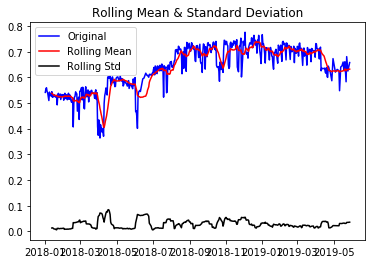

Results of Dickey-Fuller Test:
Test Statistic                  -1.793049
p-value                          0.383918
#Lags Used                      13.000000
Number of Observations Used    465.000000
Critical Value (1%)             -3.444491
Critical Value (5%)             -2.867776
Critical Value (10%)            -2.570091
dtype: float64


In [17]:
test_stationarity(accuracy['QBO'])
#the test result shows we cannot reject the null hypothesis that the time series is non-stationary.

### Step 2: Transform the series to make it stationary

In [18]:
#take first difference of the QBO time series
diff = accuracy['QBO'].diff(periods = 1)

In [19]:
#replace na with mean
diff = diff.fillna(diff.mean())

In [20]:
diff.isna().sum()

0

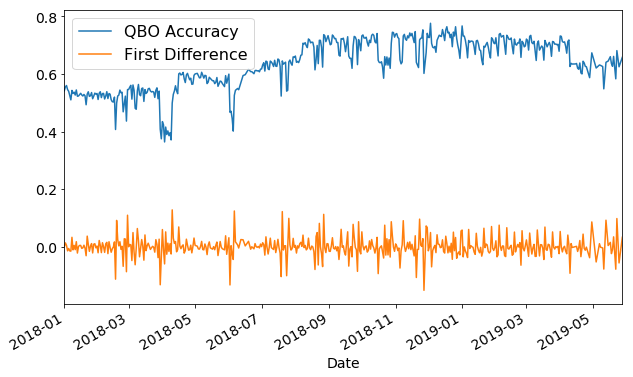

In [21]:
plt.figure(figsize=(10,6))
accuracy['QBO'].plot(legend = True, fontsize=14)
diff.plot(legend = True, fontsize=14)
plt.legend(['QBO Accuracy', 'First Difference'], fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.show()

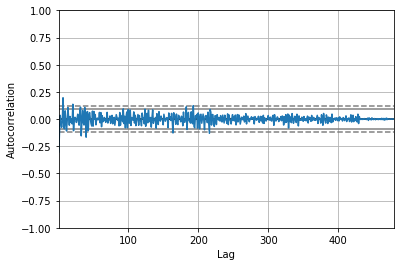

In [22]:
#plot the ACF of the first difference of the time series
autocorrelation_plot(diff)
plt.show()

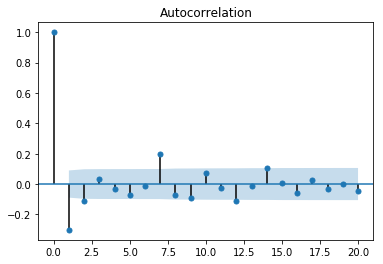

In [23]:
plot_acf(diff, lags = 20)
plt.show()

#plot the ACF of the first difference of the QBO time series in a different way

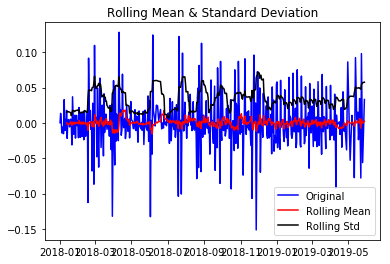

Results of Dickey-Fuller Test:
Test Statistic                -8.431501e+00
p-value                        1.864802e-13
#Lags Used                     1.200000e+01
Number of Observations Used    4.660000e+02
Critical Value (1%)           -3.444461e+00
Critical Value (5%)           -2.867762e+00
Critical Value (10%)          -2.570084e+00
dtype: float64


In [24]:
test_stationarity(diff)

#test stationarity of the first difference. 
#we reject the null hypothesis the time series is non-stationary at 1% significance level

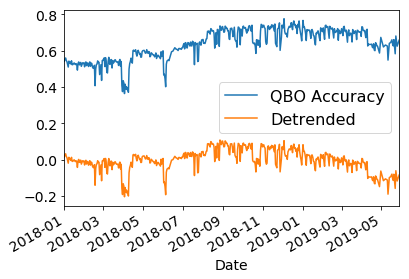

In [25]:
import scipy.signal
detrended_QBO = scipy.signal.detrend(accuracy.QBO.values)

accuracy['QBO'].plot(legend = True, fontsize=14)
plt.plot(accuracy.index, detrended_QBO)
plt.legend(['QBO Accuracy', 'Detrended'], fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.show()

#plot the detrended QBO time series and the original time series


In [26]:
detrended_QBO = pd.Series(detrended_QBO, index = accuracy.index)

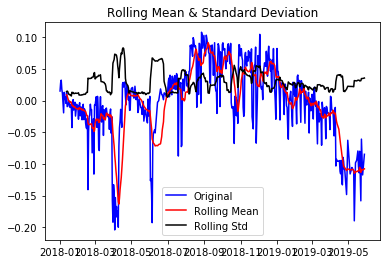

Results of Dickey-Fuller Test:
Test Statistic                  -2.139018
p-value                          0.229117
#Lags Used                      13.000000
Number of Observations Used    465.000000
Critical Value (1%)             -3.444491
Critical Value (5%)             -2.867776
Critical Value (10%)            -2.570091
dtype: float64


In [27]:
test_stationarity(detrended_QBO)
#test stationarity of the detrended QBO time series. 
#We cannot reject the hypothesis the time series is non-stationary

### Step 3: Fit ARIMA model on first difference of QBO series

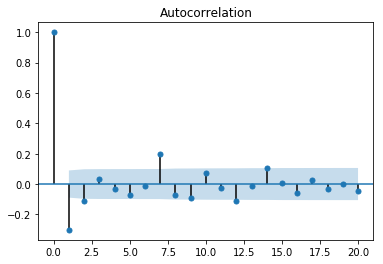

In [28]:
plot_acf(diff, lags = 20)
plt.show()
#ACF cuts off after lag 1

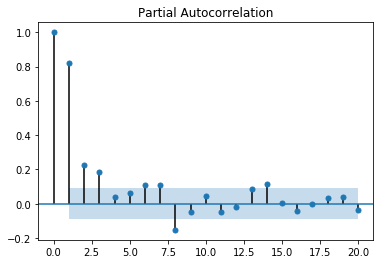

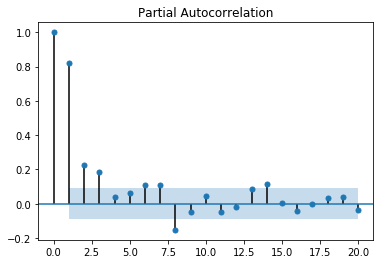

In [29]:
plot_pacf(detrended_QBO, lags = 20)
#PACF tails off

In [30]:
#fit an ARIMA model
model = ARIMA(accuracy.QBO, order = (0,1,1))

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [31]:
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.QBO   No. Observations:                  478
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 957.469
Method:                       css-mle   S.D. of innovations              0.033
Date:                Mon, 17 Jun 2019   AIC                          -1908.938
Time:                        21:03:29   BIC                          -1896.429
Sample:                             1   HQIC                         -1904.020
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.001      0.272      0.786      -0.001       0.002
ma.L1.D.QBO    -0.4812      0.049     -9.855      0.000      -0.577      -0.385
                                    Roots       

### Step 4: Diagnostic Checks on Residuals: Are residuals consistent with model assumpations?

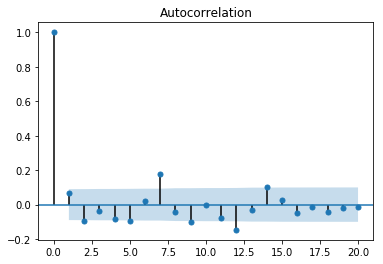

In [32]:
#plot ACF of residuals
plot_acf(model_fit.resid, lags = 20)
plt.show()

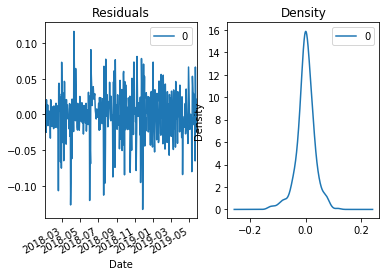

In [33]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

plt.show()

##### The residuals appear to have constant mean and variance, which is consistent with model assumptions. But they have significant high-order auto-correlations.

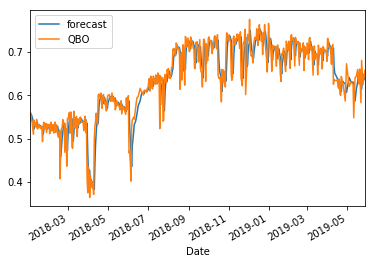

In [34]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

### Step 5: Build model on training set, forecast on test set and plot it

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:                  D.QBO   No. Observations:                  478
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 957.469
Method:                       css-mle   S.D. of innovations              0.033
Date:                Mon, 17 Jun 2019   AIC                          -1908.938
Time:                        21:16:53   BIC                          -1896.429
Sample:                             1   HQIC                         -1904.020
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.001      0.272      0.786      -0.001       0.002
ma.L1.D.QBO    -0.4812      0.049     -9.855      0.000      -0.577      -0.385
                                    Roots       

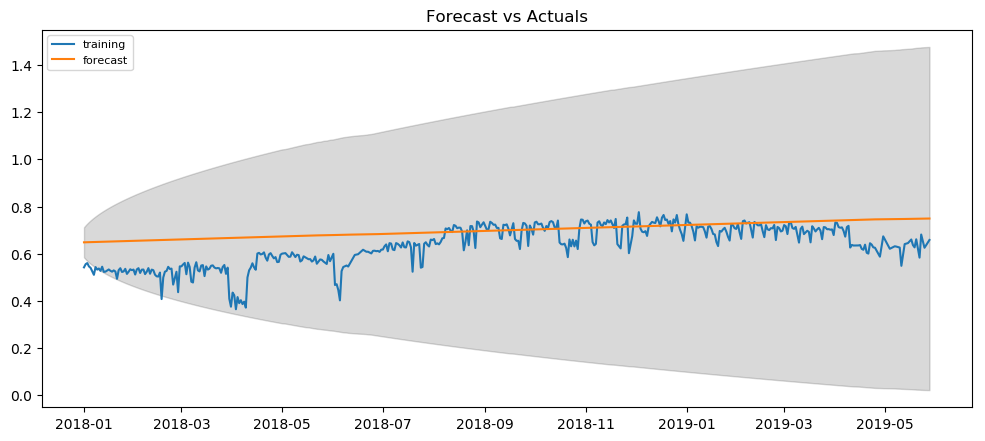

In [64]:
train = accuracy.QBO
model_train = ARIMA(train, order = (0,1,1))
fitted_train = model_train.fit(disp=-1)
print(fitted_train.summary())
# Forecast
fc, se, conf = fitted_train.forecast(len(train), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=train.index)
lower_series = pd.Series(conf[:, 0], index=train.index)
upper_series = pd.Series(conf[:, 1], index=train.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [65]:
train = accuracy.QBO[:359]
test = accuracy.QBO[360:]

In [66]:
model_train = ARIMA(train, order = (0,1,1))

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [67]:
fitted_train = model_train.fit(disp=-1)
print(fitted_train.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.QBO   No. Observations:                  358
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 703.340
Method:                       css-mle   S.D. of innovations              0.034
Date:                Mon, 17 Jun 2019   AIC                          -1400.680
Time:                        21:17:01   BIC                          -1389.038
Sample:                             1   HQIC                         -1396.050
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0005      0.001      0.441      0.660      -0.002       0.003
ma.L1.D.QBO    -0.4122      0.060     -6.924      0.000      -0.529      -0.296
                                    Roots       

### Step 6: Construct 95% confidence interval on test set - 
        if an observation falls outside the interval, it is considered an anomaly

In [60]:
119/len(accuracy.QBO)

0.24843423799582465

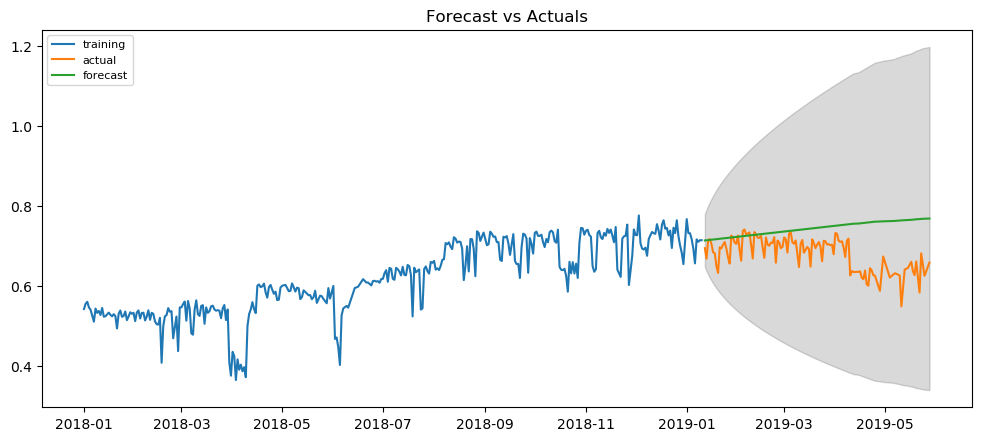

In [68]:
# Forecast
fc, se, conf = fitted_train.forecast(119, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [69]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.09118865203746768,
 'me': 0.05807561915150759,
 'mae': 0.059136176214765794,
 'mpe': 0.08974410472292312,
 'rmse': 0.07693360979470028,
 'acf1': 0.7746844921470228,
 'corr': -0.5732990235902329,
 'minmax': 0.07876049976765587}

# Use Isolation Forest to Detect Anomalies

In [41]:
# importing libaries ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import savefig
from sklearn.ensemble import IsolationForest

In [42]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go

In [43]:
accuracy = pd.read_csv("./Accuracy Revised.csv")
accuracy.Date = pd.to_datetime(accuracy['Date'])

In [44]:
accuracy = accuracy.set_index('Date')

In [45]:
accuracy.fillna(0,inplace=True)

In [46]:
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

In [47]:
clf.fit(accuracy)

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



IsolationForest(behaviour='old', bootstrap=False, contamination=0.12,
        max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
        random_state=42, verbose=0)

In [48]:
pred = clf.predict(accuracy)

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



In [49]:
accuracy['anomaly']=pred

In [50]:
outliers=accuracy.loc[accuracy['anomaly']==-1]
outlier_index=list(outliers.index)

In [51]:
#print the number of anomalies and normal points: 
#if the "anomaly" column is -1 the observation is an anomaly
#if the "anomaly" column is 1 it is normal
print(accuracy['anomaly'].value_counts())

 1    421
-1     58
Name: anomaly, dtype: int64


Number of anomalies are 58, indicated by -1

# Apply isolation forest on the 3 series separately

In [52]:
accuracy = pd.read_csv("./Accuracy Revised.csv")
accuracy.Date = pd.to_datetime(accuracy['Date'])
accuracy = accuracy.set_index('Date')

In [53]:
#QBO model performance
QBO = pd.DataFrame(accuracy, columns = ['QBO'])

clf = IsolationForest(n_estimators = 100, max_samples='auto')
clf.fit(QBO)

# predictions
pred = clf.predict(QBO)

score = clf.decision_function(QBO)

QBO['anomaly'] = pred
QBO['score'] = score

outliers=QBO.loc[QBO['anomaly']==-1]
outlier_index=list(outliers.index)

print(QBO['anomaly'].value_counts())

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



 1    431
-1     48
Name: anomaly, dtype: int64


In [54]:
#QBSE Model performance
QBSE = pd.DataFrame(accuracy, columns = ['QBSE'])

QBSE = QBSE.dropna()

clf = IsolationForest(n_estimators = 100, max_samples='auto')
clf.fit(QBSE)

# predictions
pred = clf.predict(QBSE)

score = clf.decision_function(QBSE)

QBSE['anomaly'] = pred
QBSE['score'] = score

outliers=QBSE.loc[QBSE['anomaly']==-1]
outlier_index=list(outliers.index)

print(QBSE['anomaly'].value_counts())

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



 1    428
-1     48
Name: anomaly, dtype: int64


In [55]:
Mint = pd.DataFrame(accuracy, columns = ['Mint'])

Mint = Mint.dropna()

clf = IsolationForest(n_estimators = 100, max_samples='auto')
clf.fit(Mint)

# predictions
pred = clf.predict(Mint)

score = clf.decision_function(Mint)

Mint['anomaly'] = pred
Mint['score'] = score

outliers=Mint.loc[Mint['anomaly']==-1]
outlier_index=list(outliers.index)

print(Mint['anomaly'].value_counts())

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

C:\Users\yzhou4\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.



 1    275
-1     31
Name: anomaly, dtype: int64


In [56]:
QBO.to_excel("./QBO_anomalies.xlsx")
QBSE.to_excel("./QBSE_anomalies.xlsx")
Mint.to_excel("./Mint_anomalies.xlsx")